In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!mkdir data/karen

In [4]:
!curl https://scontent-nrt1-1.cdninstagram.com/vp/9feb62bac4fd1232dc9fa06d8ef60a2b/5B7D4456/t51.2885-15/e35/18380827_208083853041745_3411566881981595648_n.jpg -o data/karen/karen_hr.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77712  100 77712    0     0  77712      0  0:00:01 --:--:--  0:00:01  118k


In [5]:
!ls data/karen

karen_hr.jpg


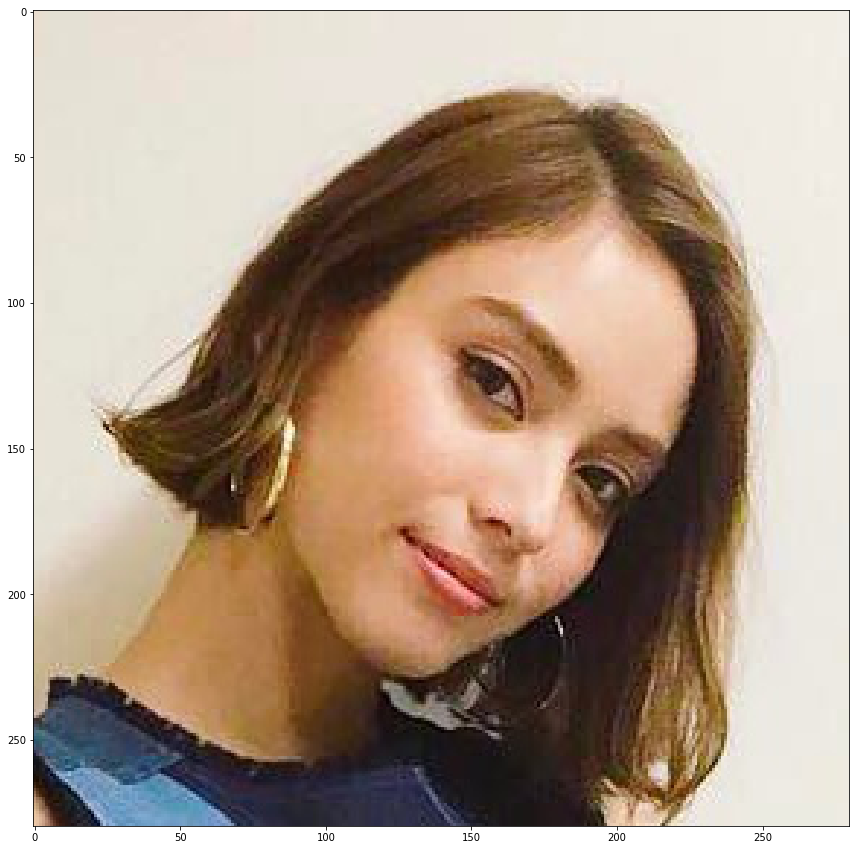

In [2]:
hr_img = cv2.imread('./data/karen/karen_hr.jpg')
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
# hr_img = hr_img[80:360, 380:660]
plt.figure(figsize = (15, 15))
plt.imshow(hr_img)
plt.show()

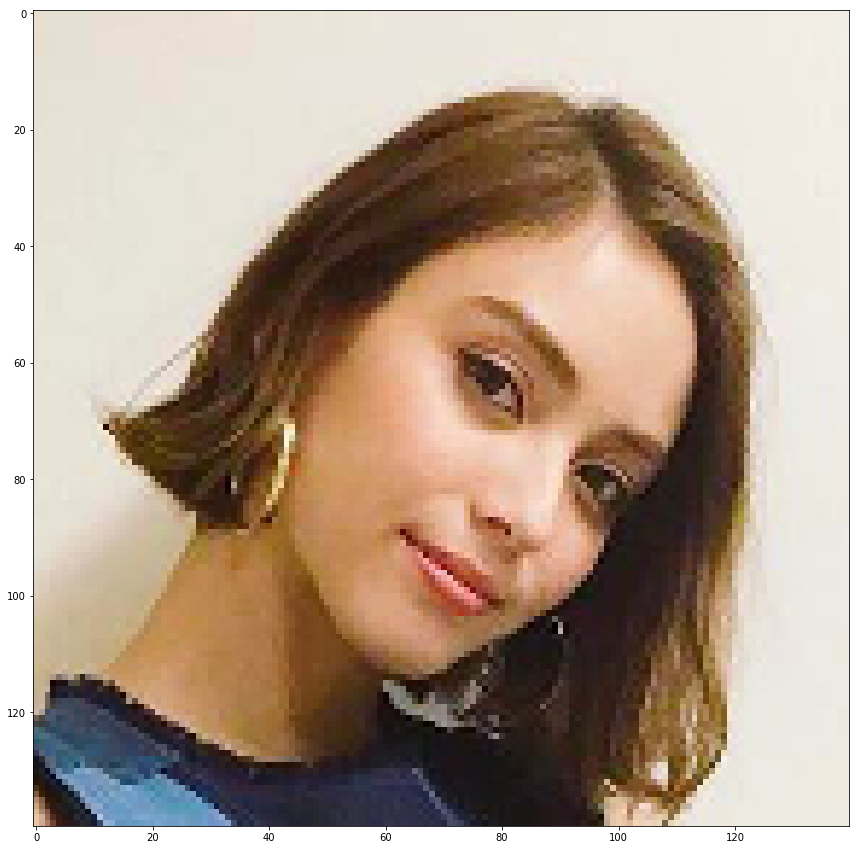

In [3]:
lr_img = cv2.resize(hr_img, None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_CUBIC)
plt.figure(figsize = (15, 15))
plt.imshow(lr_img)
plt.show()

In [9]:
def createDownscaledImage (hr_img, scalingFactor = 0.1):
    return cv2.resize(hr_img, None, fx = scalingFactor, fy = scalingFactor, interpolation = cv2.INTER_CUBIC)

def showImage (img):
    show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (10, 10))
    plt.imshow(show_img)
    plt.show()

In [35]:
cv2.imwrite("./data/karen/karen_hr.jpg", hr_img)
for index in range(10):
    scaling = (index + 1) / 10.0
    im = createDownscaledImage(hr_img, scaling)
    cv2.imwrite("./data/karen/karen-{}.jpg".format(index), im)

In [5]:
hr_img.shape

(280, 280, 3)

In [6]:
lr_img = createDownscaledImage(hr_img, 0.5)

In [7]:
lr_img.shape

(140, 140, 3)

In [10]:
def imshow (output):
    plt_img = np.clip(output.data.numpy()[0].transpose((1, 2, 0)), 0, 1)
    plt.imshow(plt_img)
    plt.show()

Deep networks are applied to image generation by learning generator/decoder networks $x = f_\theta (z)$ that map a random code vector $z$ to an image $x$

$x \in R^{3\times H \times W}, z \in R^{C' \times H' \times W'}$

$d(\cdot):R^{3\times tH \times tW} \rightarrow R^{3 \times H \times W}$

$x: HR ~ image$

$x_0: LR ~ image$

$E(x, x_0) = \|d(x) - x_0\|^2$

$ x = f_\theta(z) $

$min_{\theta} \|f_\theta (z) - x_0 \|^2 $

In [17]:
class DeepImagePriorSR(nn.Module):
    def __init__(self, input_noise, width, height, down):
        super(DeepImagePriorSR, self).__init__()

        self.input_noise = input_noise
        self.width = width
        self.height = height

        self.layer = nn.Sequential(
            nn.Conv2d(input_noise, 64, 4, padding=2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 3, 4, padding=1)
        )

        self.d_layer = nn.Sequential(
            nn.MaxPool2d(down)
        )

    def forward(self, x):
        out = self.layer(x)
        out = self.d_layer(out)
        return out

    def hr(self, x):
        out = self.layer(x)
        return out

    def make_z(self):
        return torch.randn([1, self.input_noise, self.width, self.height])

In [18]:
net = DeepImagePriorSR(32, 280, 280, 2)

In [19]:
print(net)

DeepImagePriorSR(
  (layer): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): Conv2d(64, 3, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
  (d_layer): Sequential(
    (0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
)


In [23]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

6
torch.Size([64, 32, 4, 4])


In [24]:
input = net.make_z()

In [25]:
output = net(Variable(input))

In [26]:
output.shape

torch.Size([1, 3, 140, 140])

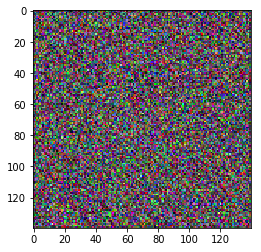

In [27]:
imshow(output)

In [144]:
output.data.numpy()[0].transpose((1, 2, 0)).shape

(140, 140, 3)

In [145]:
output = net.hr(Variable(input))
output.shape

torch.Size([1, 3, 280, 280])

In [217]:
train_data = np.array([lr_img]).transpose((0, 3, 1, 2))

In [218]:
train_data.shape

(1, 3, 140, 140)

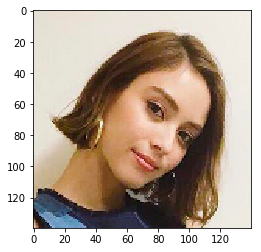

In [220]:
plt.imshow((train_data / 255)[0].transpose((1, 2, 0)))

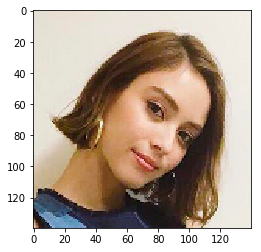

In [216]:
plt.imshow(lr_img)

In [28]:
def train(DIP, optimizer, criterion, lr_train_img, epoch=10):
    DIP.train()
    
    lr_train = Variable(
        torch.from_numpy(
            (np.array([lr_train_img]) / 255).transpose((0, 3, 1, 2))
        ).float()
    )
    
    DIP_running_loss = 0
    
    for i in range(epoch):
        z = Variable(DIP.make_z())
        
        optimizer.zero_grad()
        
        downed = DIP(z)
        loss = criterion(downed, lr_train)
        
        loss.backward()
        optimizer.step()
        
        DIP_running_loss = loss.data[0]
        
    print("loss: {}".format(DIP_running_loss))
    
    temp_z = Variable(DIP.make_z())
    
    hr = DIP.hr(temp_z)
#     plt.imshow(lr_train_img)
#     plt.show()
    imshow(hr)

In [29]:
DIP_optim = optim.Adam(net.parameters(), 0.003, betas=(0.5, 0.999))
criter = nn.MSELoss()

loss: 0.1171092540025711


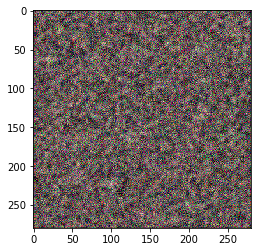

In [30]:
train(net, DIP_optim, criter, lr_img, 10)

epoch 1 / 5 - 10 training
loss: 0.09654780477285385


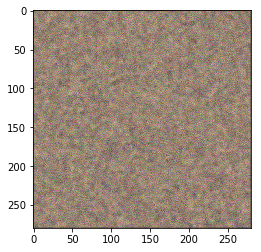

epoch 2 / 5 - 10 training
loss: 0.09537294507026672


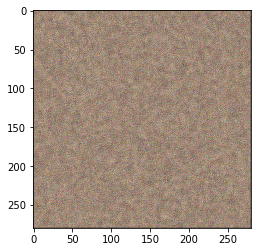

epoch 3 / 5 - 10 training
loss: 0.09622932225465775


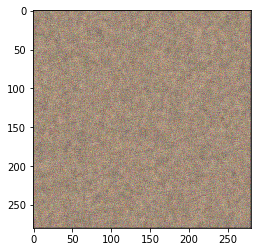

epoch 4 / 5 - 10 training
loss: 0.09472972899675369


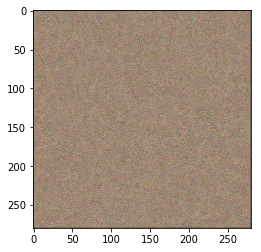

epoch 5 / 5 - 10 training
loss: 0.09429401904344559


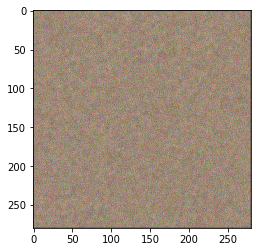

In [31]:
for i in range(5):
    print("epoch {} / 5 - 10 training".format(i + 1))
    train(net, DIP_optim, criter, lr_img, 10)